In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('C:/Users/hakim/code/ml/projects/maintenance_prediction/datasets/predictive_maintenance.csv')

In [3]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [5]:
df.apply(lambda x: x.nunique())

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Target                         2
Failure Type                   6
dtype: int64

In [6]:
df.iloc[:,-1].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

In [7]:
df_drop = df.drop(['UDI', 'Product ID', 'Target'], axis=1)
df_drop.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,M,298.1,308.6,1551,42.8,0,No Failure
1,L,298.2,308.7,1408,46.3,3,No Failure
2,L,298.1,308.5,1498,49.4,5,No Failure
3,L,298.2,308.6,1433,39.5,7,No Failure
4,L,298.2,308.7,1408,40.0,9,No Failure


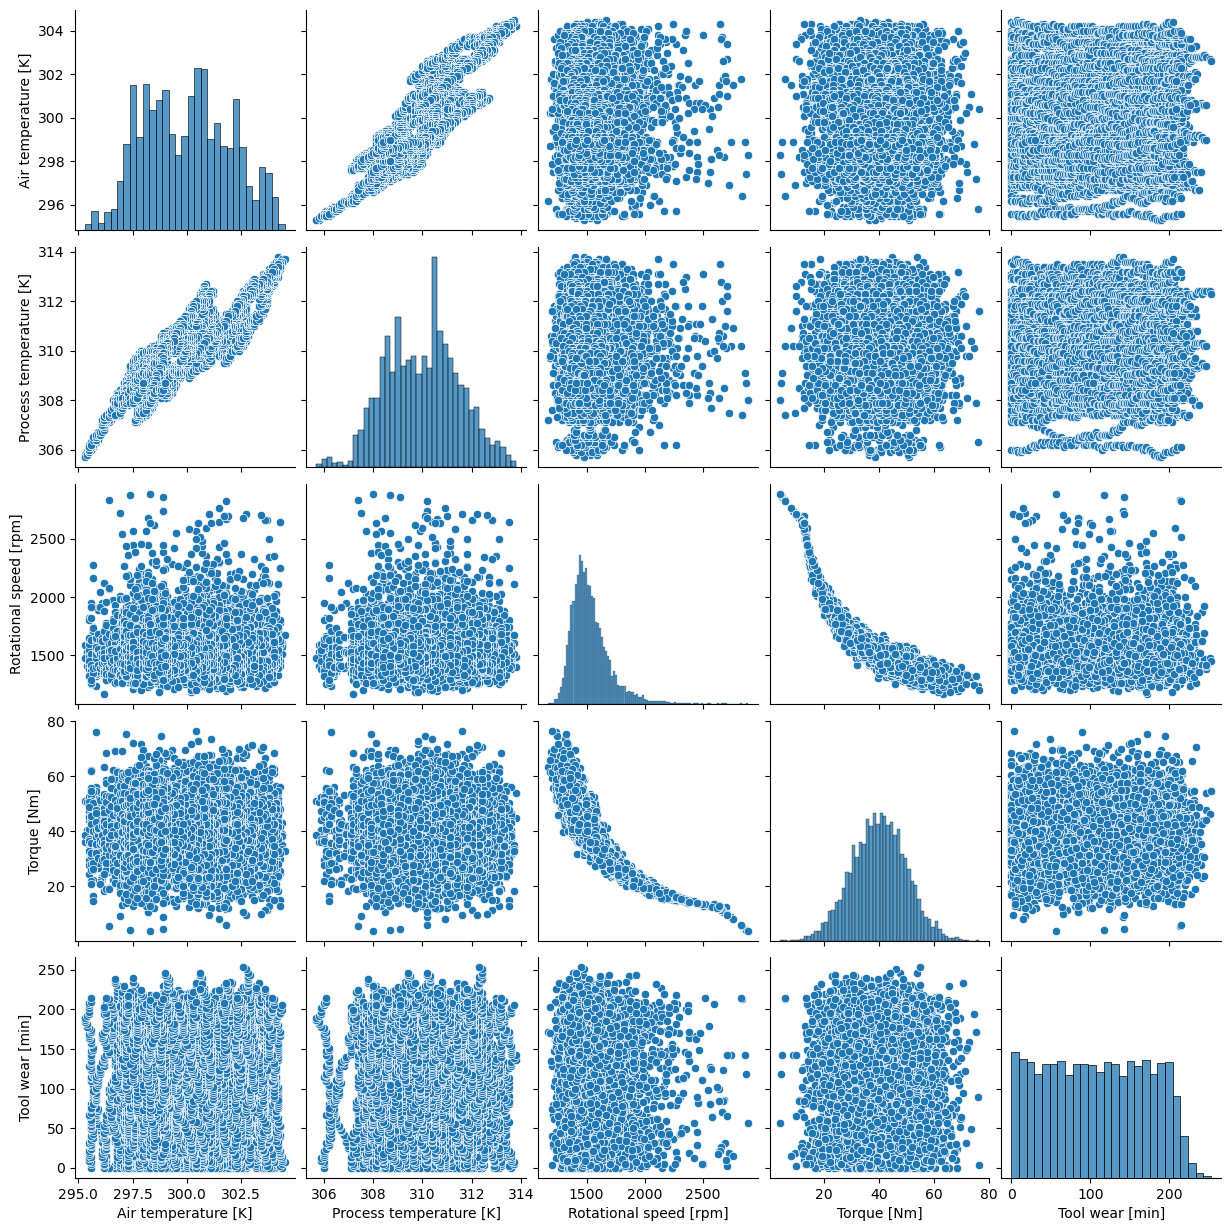

In [8]:
# Explanatory Data Analysis
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_drop)

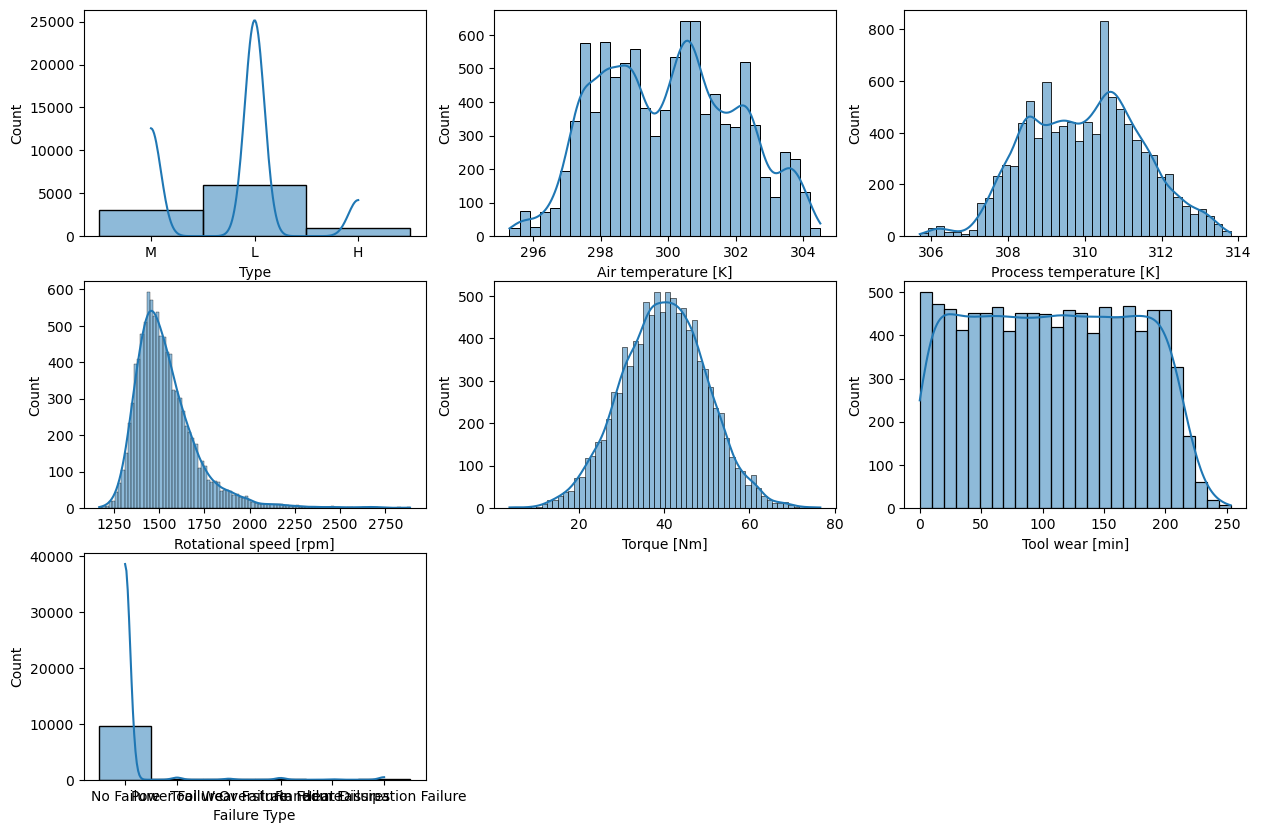

In [9]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df_drop.columns,1):
    plt.subplot(3,3,i)
    sns.histplot(df[col],kde=True)

In [10]:
# EDA Finding: 
# 1. Target (Failure Type) is unbalanced. Most all the target is on class No Failure.

In [11]:
# Encode Failure type and Machine type.
import category_encoders as ce
encoder = ce.OrdinalEncoder(cols=['Type','Failure Type'])
df_encode = encoder.fit_transform(df_drop)
df_encode.head(5)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,1,298.1,308.6,1551,42.8,0,1
1,2,298.2,308.7,1408,46.3,3,1
2,2,298.1,308.5,1498,49.4,5,1
3,2,298.2,308.6,1433,39.5,7,1
4,2,298.2,308.7,1408,40.0,9,1


In [12]:
# Found target label is unbalanced towards class = 1. Perform oversampling SMOTE. 
# Oversampling SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter

# Make data copy SMOTE
y = df_encode['Failure Type']
df_encode_smote = df_encode.values

# Resampling
smk = SMOTETomek(random_state=42)
x_smote, y_smote = smk.fit_resample(df_encode_smote, y)

print(f'Orignal Dataset Shape: {y.shape}')
print(f'SMOTE Dataset Shape: {y_smote.shape}')
print(f"Orignal Dataset Counts {Counter(y)}")
print(f"Resampled Dataset Counts {Counter(y_smote)}")

Orignal Dataset Shape: (10000,)
SMOTE Dataset Shape: (57890,)
Orignal Dataset Counts Counter({1: 9652, 6: 112, 2: 95, 4: 78, 3: 45, 5: 18})
Resampled Dataset Counts Counter({4: 9652, 5: 9652, 6: 9652, 3: 9648, 2: 9645, 1: 9641})


In [13]:
# Combine Xsmote and Ysmote into one dataframe.
df_smote = pd.concat([pd.DataFrame(x_smote), pd.DataFrame(y_smote)], axis=1)

# Insert original columns into df_smote.
df_encode.columns = df_encode.columns.astype('str')
col_names = df_encode.columns.to_list()

target_cols = col_names.pop(-1)
feature_cols = col_names

df_smote = df_smote.drop(df_smote.columns[-1], axis=1)

new_col = df_encode.columns
new_col = new_col.to_list()
df_smote.columns = new_col

df_smote = df_smote.round(decimals=0).astype(int)
df_smote.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,1,298,309,1551,43,0,1
1,2,298,309,1408,46,3,1
2,2,298,308,1498,49,5,1
3,2,298,309,1433,40,7,1
4,2,298,309,1408,40,9,1


In [14]:
df_smote['Failure Type'].value_counts()

4    9652
5    9652
6    9652
3    9648
2    9645
1    9641
Name: Failure Type, dtype: int64

In [15]:
# Set feature and target variables.
x = df_smote.drop(['Failure Type'], axis=1)
y = df_smote['Failure Type']

In [16]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
def feature_scaling(x):
    x = pd.DataFrame(x)
    x_scaled = StandardScaler().fit_transform(x)
    return x_scaled

# Feature scaling result
x_scaled = feature_scaling(x)
print(x_scaled)

[[-1.63475018 -1.40893844 -0.98002969  0.13998718 -0.23744184 -2.05220837]
 [ 0.23069083 -1.40893844 -0.98002969 -0.32179153 -0.03190768 -2.00938944]
 [ 0.23069083 -1.40893844 -1.75703636 -0.03116157  0.17362648 -1.98084349]
 ...
 [ 0.23069083  1.34321758  1.35099031 -0.46387729  0.24213787 -0.51072697]
 [ 0.23069083  0.79278638 -0.20302302 -0.47356495  0.65320618 -1.08164601]
 [ 0.23069083  1.34321758  0.57398364 -0.46064807  0.51618341 -0.62491078]]


In [17]:
# Split data into training and testing set.
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x_scaled, y, test_size=0.3)

In [18]:
# Plot confusion matrix function
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y, yhat, title, accuracy):
    cm = confusion_matrix(y, yhat)
    labels = np.unique(y)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

    plt.title(f'{title} Failure Type CM, Accuracy: {accuracy:.2f}')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()


In [26]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn import svm

# Set Stratified Kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model and Params
model = svm.SVC(gamma='auto', probability=True)
params = {'C': [1, 10, 15, 30],'kernel': ['rbf', 'poly']}

# Automate Cross Validation using GridSearch CV
clf = GridSearchCV(model, params, cv=skf, return_train_score=True)

# Training model (GridSearchCV)
clf.fit(xtrain, ytrain)

# Best parameters for SVM
clf.best_params_

{'C': 30, 'kernel': 'rbf'}

              precision    recall  f1-score   support

           1       0.97      0.86      0.91      6732
           2       1.00      1.00      1.00      6701
           3       0.96      0.99      0.97      6783
           4       0.99      0.99      0.99      6797
           5       0.91      0.97      0.94      6792
           6       0.97      1.00      0.98      6718

    accuracy                           0.97     40523
   macro avg       0.97      0.97      0.97     40523
weighted avg       0.97      0.97      0.97     40523

              precision    recall  f1-score   support

           1       0.97      0.84      0.90      2909
           2       1.00      1.00      1.00      2944
           3       0.96      0.98      0.97      2865
           4       0.99      0.99      0.99      2855
           5       0.91      0.97      0.94      2860
           6       0.97      1.00      0.98      2934

    accuracy                           0.96     17367
   macro avg       0.97

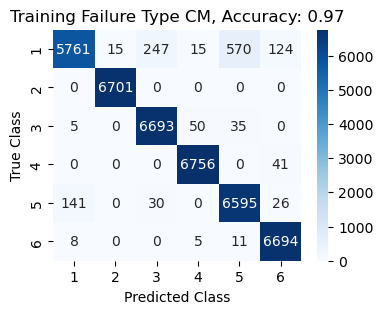

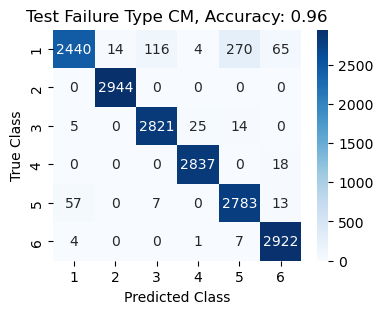

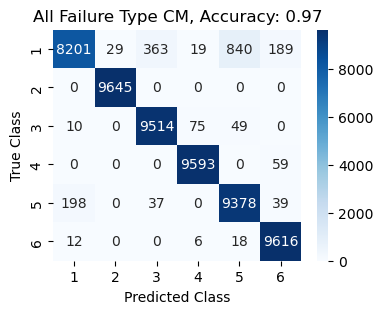

In [27]:
from sklearn.metrics import accuracy_score

# Get the best training model from cross validation.
best_model = clf.best_estimator_

# Classification report, accuracy, and confusion matrix
## Training set
yhat_train = best_model.predict(xtrain)
report_train = classification_report(ytrain, yhat_train)
acc_train = accuracy_score(ytrain, yhat_train)
print(report_train)

## Testing set
yhat_test = best_model.predict(xtest)
report_test = classification_report(ytest, yhat_test)
acc_test = accuracy_score(ytest, yhat_test)
print(report_test)

## All set
yhat_all = best_model.predict(x_scaled)
report_all = classification_report(y, yhat_all)
acc_all = accuracy_score(y, yhat_all)
print(report_all)

# Plot Confusion Matrix - Training, Testing, and All Data
plot_confusion_matrix(ytrain, yhat_train, 'Training', acc_train)
plot_confusion_matrix(ytest, yhat_test, 'Test', acc_test)
plot_confusion_matrix(y, yhat_all, 'All', acc_all)

In [50]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

yhat_probs = best_model.predict_proba(xtest)
auc_scores = roc_auc_score(ytest, yhat_probs, multi_class='ovr')
mean_auc = np.mean(auc_scores)

print(f"AUC Scores for Each Class: {auc_scores*100:.2f}%")
print(f"Mean AUC: {mean_auc*100:.2f}%")

AUC Scores for Each Class: 99.46%
Mean AUC: 99.46%


In [22]:
def predict(feature, model):
    scaler = StandardScaler()
    try_predict = np.array(feature).reshape(-1,1)
    scaler.fit_transform(x)
    try_predict_reshaped = try_predict.reshape(1, -1)
    scaled_feature = scaler.transform(try_predict_reshaped)
    predict = model.predict(scaled_feature)
    return predict

In [23]:
feature = [1, 301, 309, 1342, 59, 250]
model = best_model
predict(feature, model)

c:\Users\hakim\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([4])